In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from scipy.special import exp1,factorial
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib
import os
import glob
import json
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import binom,nbinom
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter

In [15]:
plt.rcParams['font.family']='Arial'

In [16]:
def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_prob_seg(n,w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,sigma,s)
    return 1 - ((s*rho*lc*lc*lam)/(s*rho*lc*lc*lam+n))**(mu*rho*lc*lc*lam)

def seg_allele_freq(n,w,rho,sigma,s,mu):
    pr_seg = get_prob_seg(n,w,rho,sigma,s,mu)
    return (mu/s)/pr_seg

def get_het(w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,sigma,s)
    theta = mu*rho*lc*lc*lam
    gamma = s*rho*lc*lc*lam
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_prob_seg_unif(n,s,mu,N):
    gamma = s*N
    theta = mu*N
    return 1 - (gamma/(gamma+n))**theta

def seg_allele_freq_unif(n,s,mu,N):
    prob_seg = get_prob_seg_unif(n,s,mu,N)
    return (mu/s)/prob_seg

def get_het_unif(s,mu,N):
    gamma = s*N
    theta = mu*N
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_EP_sim(ps, zeros):
    return np.sum(ps) / (len(ps) + zeros)

def get_EPsquared_sim(ps, zeros):
    return (np.sum(ps ** 2) / (len(ps) + zeros))

def get_lambda_sim(EP,EPsquared,sigma,s):
    lc = get_lc(sigma,s)
    return EP/(s*rho*lc*lc*(EPsquared-EP**2))

def load_data(file):
    with open(file, "r") as json_file:
        data = json.load(json_file)
    return data

def concatenate_data(files):
    combined_sampled_p = []
    combined_zero_samples = 0
    for f in files:
        data = load_data(f)
        combined_sampled_p.extend(data['sampled_p_flattened'])
        combined_zero_samples += data['zero_samples']
    return np.array(combined_sampled_p), combined_zero_samples

def sample_sfs(ps, zeros, n, max_allele_count=10):
    running_sfs = np.zeros(max_allele_count + 1)
    ps = np.where(ps > 1e-100, ps, 0.0)
    j = np.arange(max_allele_count)
    pmf_matrix = binom.pmf(j[:, np.newaxis], n, ps)
    running_sfs[:-1] = np.sum(pmf_matrix, axis=1)
    running_sfs[-1] = np.sum(binom.sf(max_allele_count - 1, n, ps))
    running_sfs[0] += zeros
    expected_sfs = running_sfs / np.sum(running_sfs)
    return expected_sfs

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

In [17]:
colors = ['darkorange','orchid','steelblue']
colors_n = ['mediumseagreen','deeppink','dodgerblue','blueviolet']
w_colorbar = np.linspace(10,265,20)
norm = mcolors.Normalize(vmin=w_colorbar.min(), vmax=w_colorbar.max())
cmap = cm.viridis

In [110]:
# plt.rcParams['axes.labelsize'] = 8    
# plt.rcParams['axes.titlesize'] = 9    
# plt.rcParams['xtick.labelsize'] = 8   
# plt.rcParams['ytick.labelsize'] = 8 
# plt.rcParams['legend.fontsize'] = 8

plt.rcParams['axes.labelsize'] = 12   
plt.rcParams['axes.titlesize'] = 12    
plt.rcParams['xtick.labelsize'] = 12   
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

### sigma, w, s vs. lambda

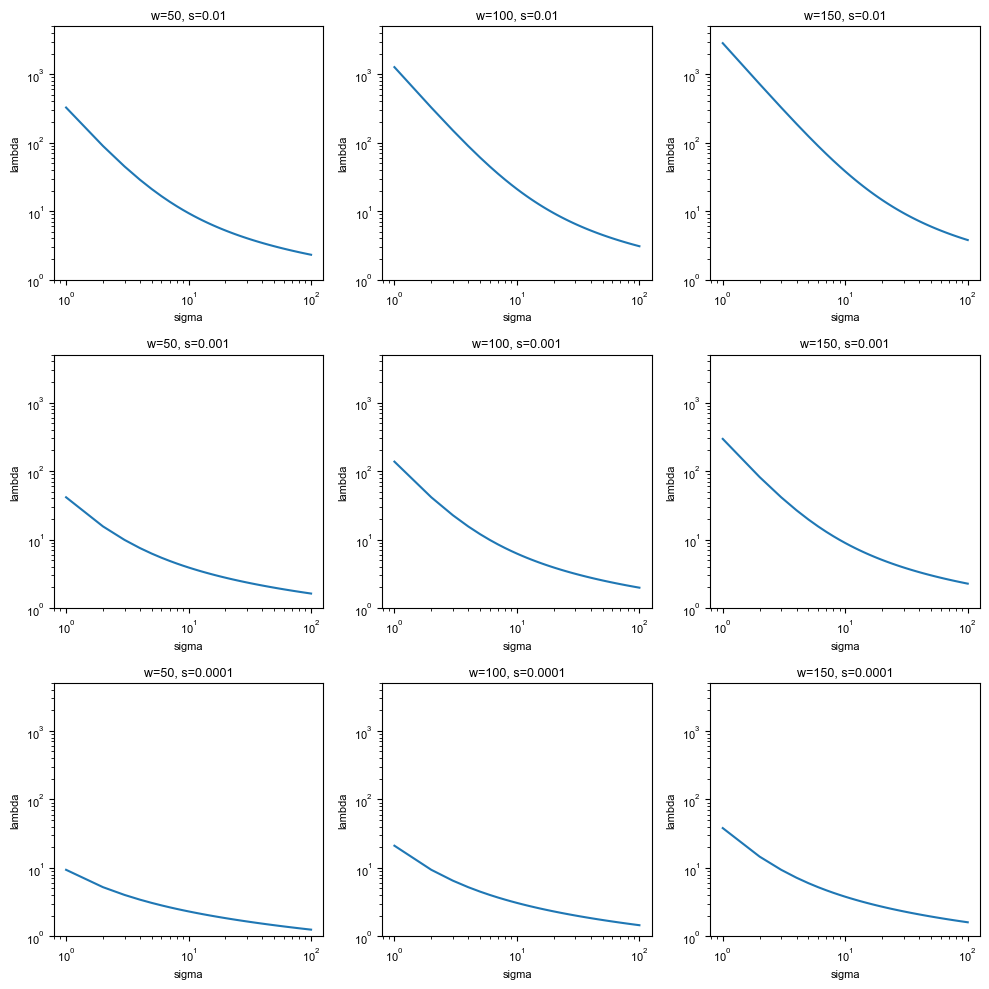

In [209]:
fig,axs = plt.subplots(3,3,figsize=(10,10))
# get_lambda_theory(w,sigma,s)


s_list = [1e-2,1e-3,1e-4]
w_list = [50,100,150]

sigma_range = np.arange(1,101)

for i,s in enumerate(s_list):
    for j,w in enumerate(w_list):
        lambda_vec = [get_lambda_theory(w,sig,s) for sig in sigma_range]
        axs[i,j].loglog(sigma_range,lambda_vec)
        axs[i,j].set_title(f'w={w}, s={s}')
        axs[i,j].set_xlabel('sigma')
        axs[i,j].set_ylabel('lambda')
        axs[i,j].set_ylim(1e0,5e3)
plt.tight_layout()
# plt.show()
plt.savefig('lambda_range.pdf')

### LOF mutation rate

using data from Samocha et al 2014 and RefSeq


In [55]:
mutrates = pd.read_csv('/Users/margaretsteiner/Downloads/gene_mut_prob_Samochaetal2014.csv')

In [56]:
mutrates

,transcript,gene,bp,all,syn,mis,non,splice_site,frameshift,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NM_017582,UBE2Q1,1269,-4.7680,-5.2654,-4.9809,-6.1980,-6.2709,-6.0949,NaN,NaN,NaN
1,NM_014372,RNF11,465,-5.1251,-5.6370,-5.3151,-6.6037,-7.0715,-6.5309,NaN,NaN,NaN
2,NM_014455,RNF115,915,-4.9092,-5.5012,-5.0788,-6.3393,-6.4484,-6.2369,NaN,NaN,NaN
3,NM_001357,DHX9,3813,-4.2966,-4.9187,-4.4646,-5.5248,-5.9450,-5.6170,NaN,NaN,NaN
4,NM_001101376,FAM183A,405,-5.2266,-5.8034,-5.3921,-6.5424,NaN,-6.5909,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18266,NM_004679,VCY,378,-5.1588,-5.5794,-5.3792,-7.0756,-7.3697,-6.6208,NaN,NaN,NaN
18267,NM_014893,NLGN4Y,2451,-4.7228,-5.1936,-4.9215,-6.2792,-7.7041,-5.8090,NaN,NaN,NaN
18268,NM_032973,PCDH11Y,4023,-4.4392,-5.0059,-4.5947,-5.9924,-7.1667,-5.5938,NaN,NaN,NaN
18269,NM_139214,TGIF2LY,558,-5.0236,-5.5419,-5.1939,-6.6937,NaN,-6.4517,NaN,NaN,NaN


In [57]:
genes = pd.read_csv('/Users/margaretsteiner/Downloads/gene_result.txt',delimiter='\t')

In [58]:
genes

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17
0,9606,Homo sapiens,4070,0,live,TACSTD2,"EGP-1, EGP1, GA733-1, GA7331, GP50, M1S1, TROP2",tumor associated calcium signal transducer 2,tumor-associated calcium signal transducer 2|4...,1p32.1,1,NC_000001.11,58575433.0,58577252.0,minus,1.0,137290.0,NaN
1,9606,Homo sapiens,2060,0,live,EPS15,"AF-1P, AF1P, MLLT5",epidermal growth factor receptor pathway subst...,epidermal growth factor receptor substrate 15|...,1p32.3,1,NC_000001.11,51354263.0,51519266.0,minus,26.0,600051.0,NaN
2,9606,Homo sapiens,4524,0,live,MTHFR,NaN,methylenetetrahydrofolate reductase,"methylenetetrahydrofolate reductase (NADPH)|5,...",1p36.22,1,NC_000001.11,11785723.0,11805964.0,minus,13.0,607093.0,NaN
3,9606,Homo sapiens,100874054,0,live,FALEC,"FAL1, LINC00568, ncRNA-a1",focally amplified lncRNA regulator of ECM1,focally amplified lncRNA on chromosome 1|focal...,1q21.2,1,NC_000001.11,150515752.0,150536788.0,plus,6.0,616092.0,NaN
4,9606,Homo sapiens,3586,0,live,IL10,"CSIF, GVHDS, IL-10A, TGIF, IL10",interleukin 10,interleukin-10|T-cell growth inhibitory factor...,1q32.1,1,NC_000001.11,206767602.0,206772494.0,minus,7.0,124092.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18215,9606,Homo sapiens,127138872,0,live,LOC127138872,NaN,OCT4-NANOG-H3K27ac-H3K4me1 hESC enhancer GRCh3...,NaN,NaN,NaN,NT_113793.3,3973.0,4788.0,plus,0.0,NaN,NaN
18216,9606,Homo sapiens,127138871,0,live,LOC127138871,NaN,OCT4-NANOG-H3K27ac hESC enhancer GRCh37_chr1:1...,NaN,NaN,NaN,NT_113793.3,2340.0,3155.0,plus,0.0,NaN,NaN
18217,9606,Homo sapiens,127138870,0,live,LOC127138870,NaN,OCT4-NANOG-H3K27ac-H3K4me1 hESC enhancer GRCh3...,NaN,NaN,NaN,NT_113793.3,1523.0,2339.0,plus,0.0,NaN,NaN
18218,9606,Homo sapiens,127138869,0,live,LOC127138869,NaN,OCT4-NANOG-H3K27ac-H3K4me1 hESC enhancer GRCh3...,NaN,NaN,NaN,NT_113793.3,707.0,1522.0,plus,0.0,NaN,NaN


In [59]:
genes_list = genes['Symbol'].values

In [60]:
genes_list

array(['TACSTD2', 'EPS15', 'MTHFR', ..., 'LOC127138870', 'LOC127138869',
       'LOC124906656'], dtype=object)

In [61]:
mutrates_chr1 = mutrates[mutrates['gene'].isin(genes_list)]

In [62]:
mutrates_chr1

,transcript,gene,bp,all,syn,mis,non,splice_site,frameshift,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NM_017582,UBE2Q1,1269,-4.7680,-5.2654,-4.9809,-6.1980,-6.2709,-6.0949,NaN,NaN,NaN
1,NM_014372,RNF11,465,-5.1251,-5.6370,-5.3151,-6.6037,-7.0715,-6.5309,NaN,NaN,NaN
2,NM_014455,RNF115,915,-4.9092,-5.5012,-5.0788,-6.3393,-6.4484,-6.2369,NaN,NaN,NaN
3,NM_001357,DHX9,3813,-4.2966,-4.9187,-4.4646,-5.5248,-5.9450,-5.6170,NaN,NaN,NaN
5,NM_001042549,NSL1,642,-5.0230,-5.5779,-5.2049,-6.3905,-6.7514,-6.3908,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17755,NM_002637,PHKA1,3672,-4.2960,-4.9109,-4.4691,-5.5493,-5.8244,-5.6334,NaN,NaN,NaN
17783,NM_001017930,DCAF8L1,1803,-4.5574,-5.1023,-4.7292,-5.9533,-7.7918,-5.9423,NaN,NaN,NaN
17798,NM_006743,RBM3,474,-5.1629,-5.7768,-5.3081,-6.9597,-6.8125,-6.5225,NaN,NaN,NaN
18266,NM_004679,VCY,378,-5.1588,-5.5794,-5.3792,-7.0756,-7.3697,-6.6208,NaN,NaN,NaN


In [63]:
bp_chr1 = 248387328
mutrates_chr1['non_bp']= 10**(mutrates_chr1['non'])/bp_chr1
mutrates_chr1['splice_site_bp']= 10**(mutrates_chr1['splice_site'])/bp_chr1
mutrates_chr1['frameshift_bp']= 10**(mutrates_chr1['frameshift'])/bp_chr1

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/4075733965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutrates_chr1['non_bp']= 10**(mutrates_chr1['non'])/bp_chr1
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/4075733965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutrates_chr1['splice_site_bp']= 10**(mutrates_chr1['splice_site'])/bp_chr1
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/4075733965.py:4: SettingWithCopyWarning: 
A value is tr

In [64]:
mutrates_chr1

,transcript,gene,bp,all,syn,mis,non,splice_site,frameshift,Unnamed: 9,Unnamed: 10,Unnamed: 11,non_bp,splice_site_bp,frameshift_bp
0,NM_017582,UBE2Q1,1269,-4.7680,-5.2654,-4.9809,-6.1980,-6.2709,-6.0949,NaN,NaN,NaN,2.551941e-15,2.157598e-15,3.235717e-15
1,NM_014372,RNF11,465,-5.1251,-5.6370,-5.3151,-6.6037,-7.0715,-6.5309,NaN,NaN,NaN,1.002699e-15,3.414842e-16,1.185688e-15
2,NM_014455,RNF115,915,-4.9092,-5.5012,-5.0788,-6.3393,-6.4484,-6.2369,NaN,NaN,NaN,1.843192e-15,1.433741e-15,2.333300e-15
3,NM_001357,DHX9,3813,-4.2966,-4.9187,-4.4646,-5.5248,-5.9450,-5.6170,NaN,NaN,NaN,1.202460e-14,4.569520e-15,9.724574e-15
5,NM_001042549,NSL1,642,-5.0230,-5.5779,-5.2049,-6.3905,-6.7514,-6.3908,NaN,NaN,NaN,1.638214e-15,7.136258e-16,1.637082e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17755,NM_002637,PHKA1,3672,-4.2960,-4.9109,-4.4691,-5.5493,-5.8244,-5.6334,NaN,NaN,NaN,1.136503e-14,6.032128e-15,9.364197e-15
17783,NM_001017930,DCAF8L1,1803,-4.5574,-5.1023,-4.7292,-5.9533,-7.7918,-5.9423,NaN,NaN,NaN,4.483019e-15,6.502353e-17,4.598017e-15
17798,NM_006743,RBM3,474,-5.1629,-5.7768,-5.3081,-6.9597,-6.8125,-6.5225,NaN,NaN,NaN,4.417439e-16,6.199698e-16,1.208845e-15
18266,NM_004679,VCY,378,-5.1588,-5.5794,-5.3792,-7.0756,-7.3697,-6.6208,NaN,NaN,NaN,3.382755e-16,1.718583e-16,9.639856e-16


In [67]:
mut_rate_lof = mutrates_chr1['non_bp'].sum()+mutrates_chr1['splice_site_bp'].sum()+mutrates_chr1['frameshift_bp'].sum()
mut_rate_lof

1.7154752452812103e-11

## figure

In [66]:
data_pca = pd.read_csv('../empirical/subsampling_SIR_vF/notebooks/combined_lof_pca.csv')
data_geo = pd.read_csv('../empirical/subsampling_SIR_vF/notebooks/combined_lof_geo.csv')

In [10]:
# data_pca

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/904585693.py:32: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/904585693.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65948/904585693.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_65

rho 2.5, sigma 1, s 0.0001, w 50, theta 4.019228077062367e-06, gamma 23.42923972886308
rho 2.5, sigma 1, s 0.0001, w 100, theta 9.03722355205088e-06, gamma 52.68058269514376
rho 2.5, sigma 1, s 0.0001, w 150, theta 1.6340527610960787e-05, gamma 95.25364854963067
rho 2.5, sigma 1, s 0.0001, w 500, theta 0.00013992902942570128, gamma 815.6866723119828
rho 2.5, sigma 1, s 1e-05, w 50, theta 1.6758321222310678e-05, gamma 9.768908801457851
rho 2.5, sigma 1, s 1e-05, w 100, theta 2.675077244916671e-05, gamma 15.593796834288668
rho 2.5, sigma 1, s 1e-05, w 150, theta 3.8171909701251114e-05, gamma 22.251507158876997
rho 2.5, sigma 1, s 1e-05, w 500, theta 0.00017755735361393063, gamma 103.5033027158748
rho 2.5, sigma 5, s 0.0001, w 50, theta 3.303487376894114e-05, gamma 192.5698074618727
rho 2.5, sigma 5, s 0.0001, w 100, theta 4.8279529683831305e-05, gamma 281.4353038123675
rho 2.5, sigma 5, s 0.0001, w 150, theta 6.417570146915349e-05, gamma 374.0986740886107
rho 2.5, sigma 5, s 0.0001, w 50

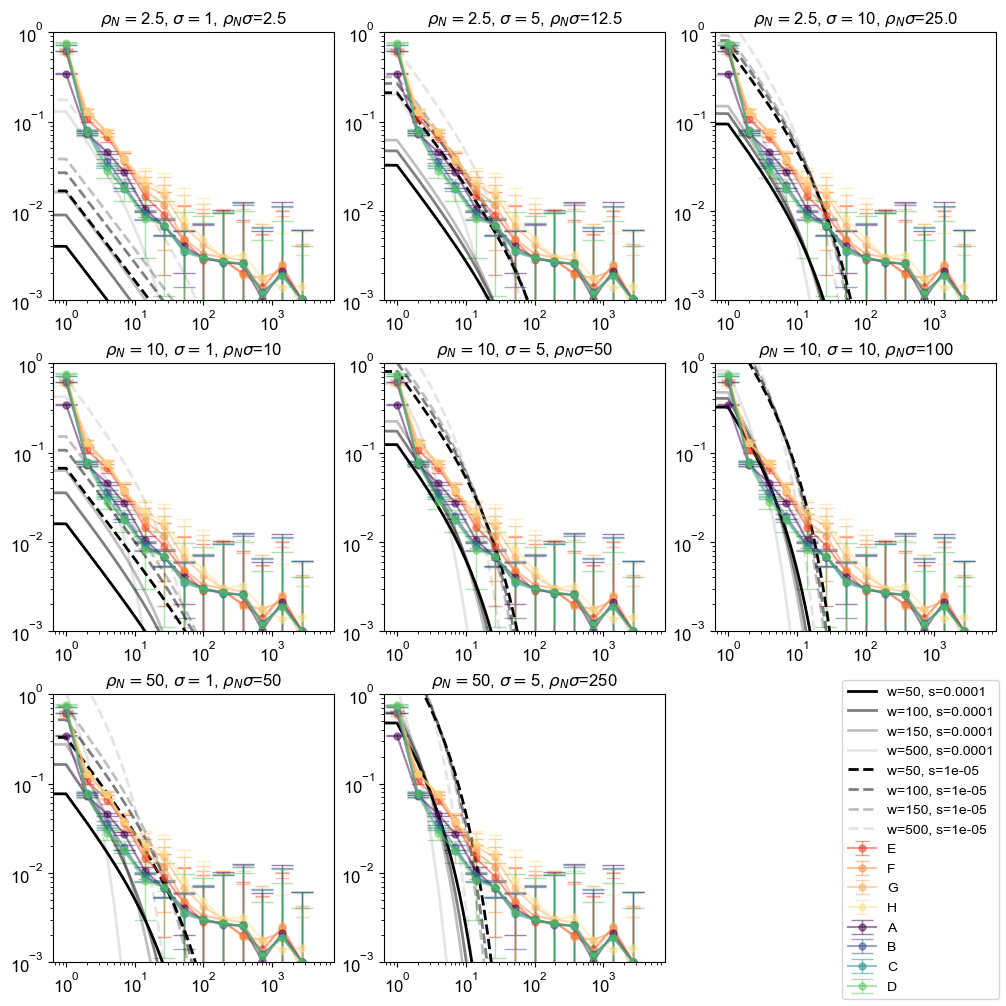

In [115]:
fig, axs = plt.subplots(3,3,figsize=(10,10))#(7.01,7.01))


max_x=1e2
n=10000 # cannot change
rho_vals = [2.5,10,50]
sigma_vals = [1,5,10]
s_vals = [1e-4,1e-5]
mu = mut_rate_lof
w_list = [50,100,150,500] # from sampling scheme
alphas = [1,0.5,0.25,0.1]
ls = ['-','--','dotted']
colors = ['#440154',  
          '#3b528b',  
          '#21918c',  
          '#5ec962',  
          '#f03b20',  
          '#fd8d3c',  
          '#fdae61',  
          '#fee08b']  
wlist_pca = ['0.0015','0.0025','0.005']
wlist_geo = ['50000','100000','150000']
# colors = ['firebrick','darkorange','steelblue']
labs_geo = ['A','B','C','D']
labs_pca = ['E','F','G','H']
for i,rho in enumerate(rho_vals):
    for j,sigma in enumerate(sigma_vals):

        # plot ukb - pca
        for m,wtemp in enumerate(wlist_pca):
            data_temp = data_pca[data_pca['w']==wtemp]
            axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
                                             yerr=data_temp['std_binned'], label=labs_pca[m],
                                             linestyle='-', marker='o', capsize=5,
                                             markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[m+4])
        data_temp = data_pca[data_pca['w']=='uniform']
        axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
                                             yerr=data_temp['std_binned'], label=labs_pca[3],
                                             linestyle='-', marker='o', capsize=5,
                                             markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[7])
            # print(data_temp)
        # plot ukb - geo
        for m,wtemp in enumerate(wlist_geo):
            data_temp = data_geo[data_geo['w']==wtemp]
            axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
                                             yerr=data_temp['std_binned'], label=labs_geo[m],
                                             linestyle='-', marker='o', capsize=8,
                                             markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[m])
        data_temp = data_geo[data_geo['w']=='uniform']
        axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
                                             yerr=data_temp['std_binned'], label=labs_geo[3],
                                             linestyle='-', marker='o', capsize=8,
                                             markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[3])
        

        
        axs[i,j].set_title(rf'$\rho_N=${rho}, $\sigma=${sigma}, $\rho_N\sigma$={rho*sigma}')
        axs[i,j].set_ylim(1e-3,1e0)
        
        #N = L*L*rho
        for k,s in enumerate(s_vals):
            # nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
            # axs[i,j].loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='steelblue',linewidth=2,linestyle=ls[k])
            for q,w in enumerate(w_list):
                lc = get_lc(sigma,s)
                lam = get_lambda_theory(w,sigma,s)
                theta = mu*rho*lc*lc*lam
                gamma = s*rho*lc*lc*lam
                # axs[i,j].axhline(theta,linestyle=ls[k],alpha=alphas[q])
                nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
                axs[i,j].loglog(np.arange(0, max_x), nb_dist, label=f'w={w}, s={s}', marker=None, linestyle=ls[k],
                                      linewidth=2, alpha=alphas[q], color='black')
                print(f'rho {rho}, sigma {sigma}, s {s}, w {w}, theta {theta}, gamma {gamma}')
                # print(theta)
                # print(gamma)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles,labels,loc='lower right')

axs[2,2].remove()


plt.tight_layout(pad=0.5)
plt.savefig('theory_data_v4.pdf')
plt.show()

In [113]:
# fig, axs = plt.subplots(3,3,figsize=(10,10))#(7.01,7.01))

# max_x=1e4
# n=10000 # cannot change
# rho_vals = [1e-2,1e-1,5e-1]
# sigma_vals = [1,5,10]
# s_vals = [1e-2,1e-3,1e-4]
# mu = 1.3e-8
# w_list = [50,100,150] # from sampling scheme
# alphas = [1,0.5,0.2]
# ls = ['-','--','dotted']
# colors = ['#440154',  
#           '#3b528b',  
#           '#21918c',  
#           '#5ec962',  
#           '#f03b20',  
#           '#fd8d3c',  
#           '#fdae61',  
#           '#fee08b']  
# wlist_pca = ['0.0015','0.0025','0.005']
# wlist_geo = ['50000','100000','150000']
# # colors = ['firebrick','darkorange','steelblue']
# labs_geo = ['A','B','C','D']
# labs_pca = ['E','F','G','H']
# for i,rho in enumerate(rho_vals):
#     for j,sigma in enumerate(sigma_vals):

#         # plot ukb - pca
#         for m,wtemp in enumerate(wlist_pca):
#             data_temp = data_pca[data_pca['w']==wtemp]
#             axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
#                                              yerr=data_temp['std_binned'], label=labs_pca[m],
#                                              linestyle='-', marker='o', capsize=5,
#                                              markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[m+4])
#         data_temp = data_pca[data_pca['w']=='uniform']
#         axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
#                                              yerr=data_temp['std_binned'], label=labs_pca[3],
#                                              linestyle='-', marker='o', capsize=5,
#                                              markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[7])
#             # print(data_temp)
#         # plot ukb - geo
#         for m,wtemp in enumerate(wlist_geo):
#             data_temp = data_geo[data_geo['w']==wtemp]
#             axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
#                                              yerr=data_temp['std_binned'], label=labs_geo[m],
#                                              linestyle='-', marker='o', capsize=8,
#                                              markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[m])
#         data_temp = data_geo[data_geo['w']=='uniform']
#         axs[i,j].errorbar(data_temp['log_bins'], data_temp['sfs_avg_binned'],
#                                              yerr=data_temp['std_binned'], label=labs_geo[3],
#                                              linestyle='-', marker='o', capsize=8,
#                                              markersize=5, elinewidth=1, fmt='o', alpha=0.5, color=colors[3])
        

        
#         axs[i,j].set_title(rf'$\rho_N=${rho}, $\sigma=${sigma}')
#         axs[i,j].set_ylim(1e-3,1e0)
        
#         N = L*L*rho
#         for k,s in enumerate(s_vals):
#             # nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
#             # axs[i,j].loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='steelblue',linewidth=2,linestyle=ls[k])
#             for q,w in enumerate(w_list):
#                 nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
#                 axs[i,j].loglog(np.arange(0, max_x), nb_dist, label=f'w={w}, s={s}', marker=None, linestyle=ls[k],
#                                       linewidth=2, alpha=alphas[q], color='black')

# plt.legend(loc='upper right')




# plt.tight_layout(pad=0.5)
# plt.savefig('theory_data_v3.pdf')
# plt.show()